In [1]:
import numpy as np 
from scipy.special import softmax 
import time 

from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns 

import sys 
sys.path.append("..") 
from utils.env import frozen_lake
from utils.viz import viz 
viz.get_style()

In [2]:
seed = 1234 
env = frozen_lake(seed=seed)
env.reset()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
env.render(ax)

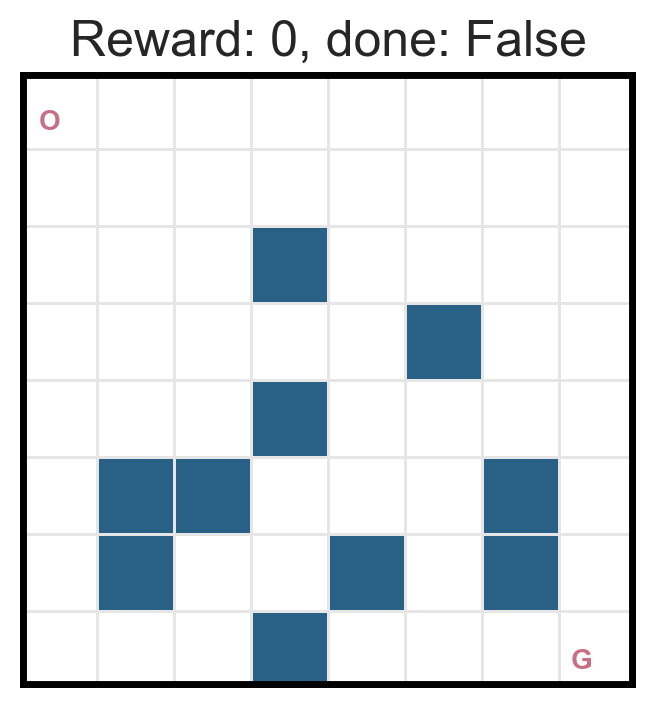

In [3]:
fig

# 介绍一下这个frozen_lake的游戏
* env.reset() 重置agent的位置到起始点
* env.step(a) a=[0, 1, 2, 3,] 代表上下左右
* env.p_s_next(s, a) 输入当前state s 和 action a, 输出转移到所有其他state的概率的向量
* env.r(s) 到达某个state时，返回(reward, bool done or not)
* env.s_termination 返回所有的终点的state, 包括窟窿和终点
* env.show_v(ax, V)  把所有状态的value画出来
* env.A, env.S 展示所有的action和state

# 1. Policy Iteration 

### 1.1 Policy evaluation 

In [ ]:
# a random policy 
rng = np.random.RandomState(1234)
pi_rand = softmax(rng.rand(env.nS, env.nA)*5, axis=1)
pi_rand
# pi_rand是一个64 (state) x 4 (action)的矩阵，代表在某个state下执行四个action的概率

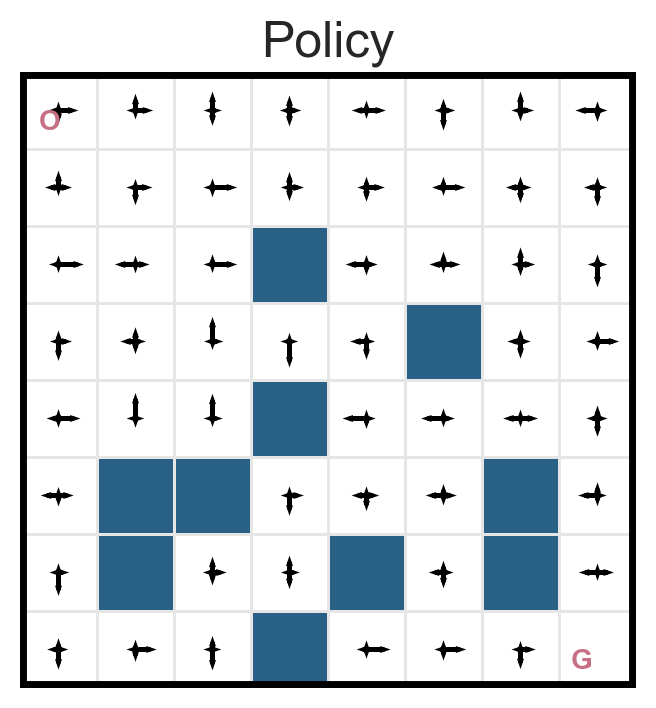

In [6]:
# visualize the policy using env.show_pi
_, ax = plt.subplots(1, 1, figsize=(4, 4))
env.show_pi(ax, pi_rand)
plt.show()

In [7]:
def policy_eval(pi, V, env, theta=1e-4, gamma=.99, show_value=False):

    # except v(terminal) = 0
    for s in env.s_termination:
        V[s] = 0

    # loop until convergence
    while True: 
        delta = 0
        for s in env.S:
            if s not in env.s_termination:
                v_old = V[s].copy()
                v_new = 0
                for a in env.A:
                    p = env.p_s_next(s, a)
                    for s_next in env.S:
                        r, done = env.r(s_next)
                        v_new += pi[s, a]*p[s_next]*(r + (1-done)*gamma*V[s_next])
                V[s] = v_new 
                # check convergence
                delta = np.max([delta, np.abs(v_new - v_old)])

        # visualize your results
        if show_value:
            _, ax = plt.subplots(1, 1, figsize=(4, 4))
            clear_output(True)
            env.show_v(ax, V)
            time.sleep(1)
            plt.show()
        
        # check convergence
        if delta < theta: break 
    
    return V

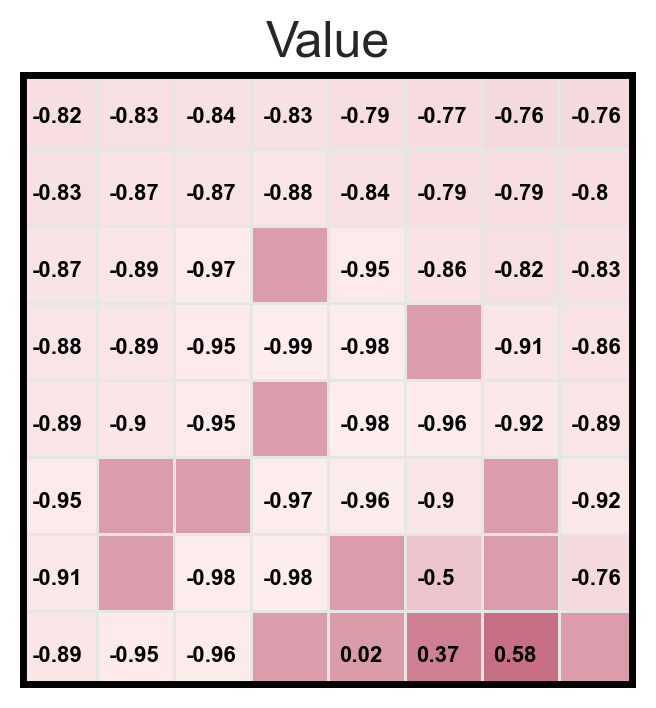

In [8]:
V_pe = np.zeros([env.nS,])
V_pe = policy_eval(pi_rand, V_pe, env, show_value=True)

### 1.2 Policy improvement

In [13]:
def policy_improve(pi, V, env, theta=1e-4, gamma=.99):
    pi_old = pi.copy()
    # initialize q
    q=np.zeros((env.nS, env.nA))
    for s in env.S:
        for a in env.A:
            # calculate q for each s and a 
            p=env.p_s_next(s,a)
            for s_next in env.S:
                r, done=env.r(s_next)
                q[s,a]+=p[s_next]*(r+(1-done)*gamma*V[s_next])
        # update pi for each s using argmax, final in one-hot encoded
        best_action=np.argmax(q[s])
        pi[s]=np.eye(env.nA)[best_action]

    # pi=q // np.max(q, axis=1, keepdims=True) 
    # check stable
    stable = (np.abs(pi - pi_old) < theta).all()
    return pi, stable  

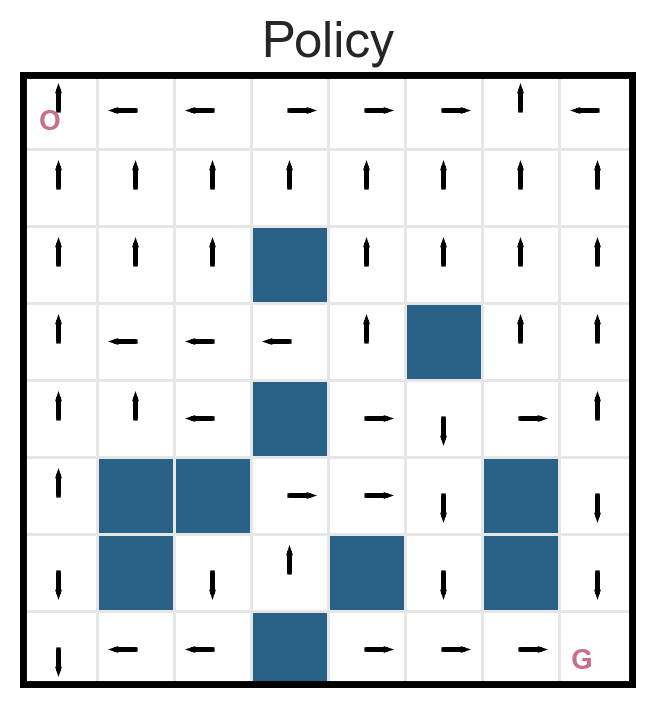

In [15]:
pi_new, stable = policy_improve(pi_rand, V_pe, env, theta=1e-4, gamma=.99)
_, ax = plt.subplots(1, 1, figsize=(4, 4))
env.show_pi(ax, pi_new)
plt.show()

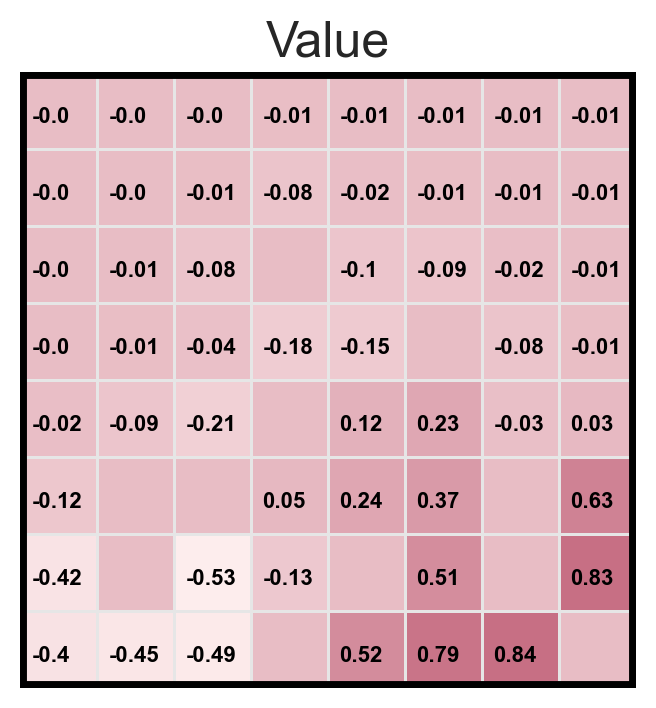

In [16]:
V_new = np.zeros([env.nS,])
V_new = policy_eval(pi_new, V_new, env, show_value=True)


### 1.3 Policy iteration 

In [ ]:
def policy_iter(env, seed=1234, show_value_pi=False):

    rng = np.random.RandomState(seed)

    # initialize V(s), arbitrarily
    V = rng.rand(env.nS) * 0.001
    # except v(terminal) = 0
    for s in env.s_termination: V[s] = 0
    # initialize π(s), arbitrarily
    pi = softmax(rng.rand(env.nS, env.nA)*5, axis=1)

    while True: 

        V = policy_eval(pi, V, env)
        pi, stable = policy_improve(pi, V, env)

        # visualize 
        if show_value_pi:
            fig, axs = plt.subplots(1, 2, figsize=(8, 4))
            clear_output(True)
            ax = axs[0]
            env.show_v(ax, V)
            ax = axs[1]
            env.show_pi(ax, pi)
            time.sleep(.1)
            plt.show()

        # check convergence
        if stable: break 

    return V, pi 

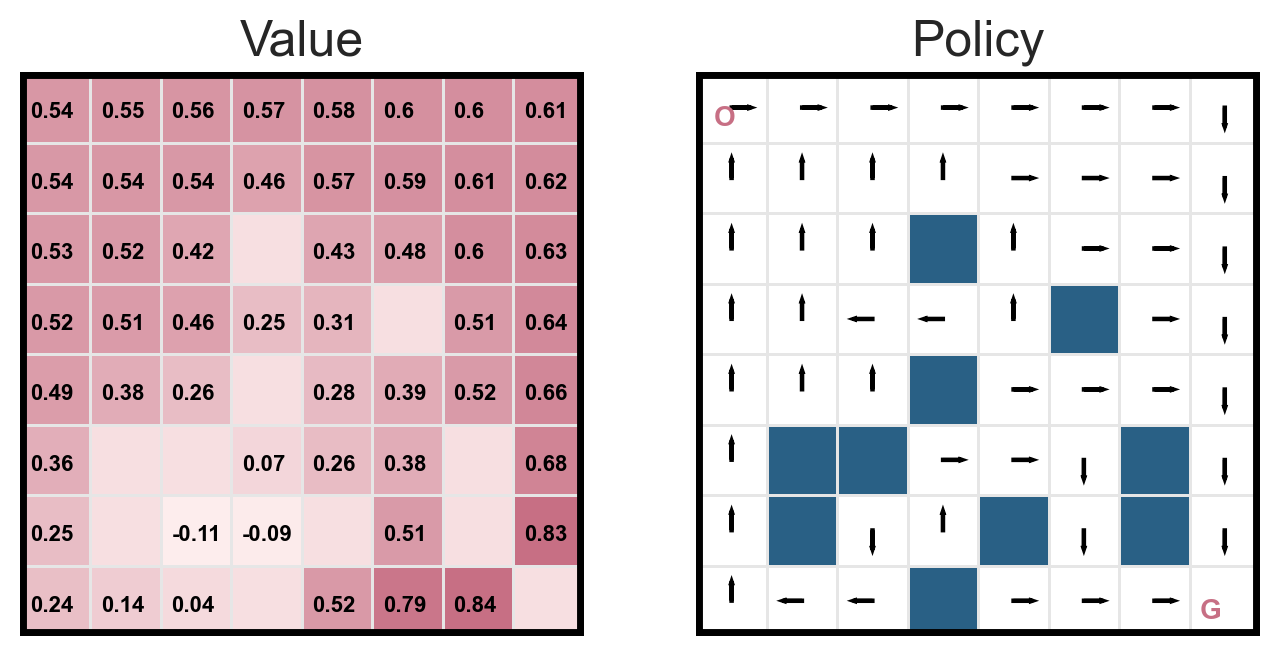

In [20]:
V1, pi1 = policy_iter(env, show_value_pi=True)

# 2. Value Iteration 

In [27]:
def value_iter(env, seed=1234, theta=1e-4, gamma=.99, show_value_pi=False):
    
    rng = np.random.RandomState(seed)
    pi = rng.rand(env.nS, env.nA)
    # initialize V(s), arbitrarily, all zero
    V = np.zeros([env.nS,])

    # loop until converge
    while True:
        delta = 0
        for s in env.S:
            if s not in env.s_termination:
                v_old = V[s].copy()
                # initalize q for the given s
                q=np.zeros((env.nA))
                for a in env.A:
                    # calculate q for each s and a 
                    p=env.p_s_next(s,a)
                    for s_next in env.S:
                        r,done=env.r(s_next)
                        q[a]+=p[s_next]*(r+(1-done)*gamma*V[s_next])
                # calculate V and update
                V[s]=np.max(q)
                # update pi using argmax
                pi[s]=np.eye(env.nA)[np.argmax(q)]
                # please ensure the pi is one-hot encoded
                delta = np.max([delta, np.abs(V[s] - v_old)])

        # visualize 
        if show_value_pi:
            fig, axs = plt.subplots(1, 2, figsize=(8, 4))
            clear_output(True)
            ax = axs[0]
            env.show_v(ax, V)
            ax = axs[1]
            env.show_pi(ax, pi)
            time.sleep(.1)
            plt.show()
        
        if delta < theta: break 

    for s in env.s_termination: V[s] = 0    
    
    return V, pi 
        

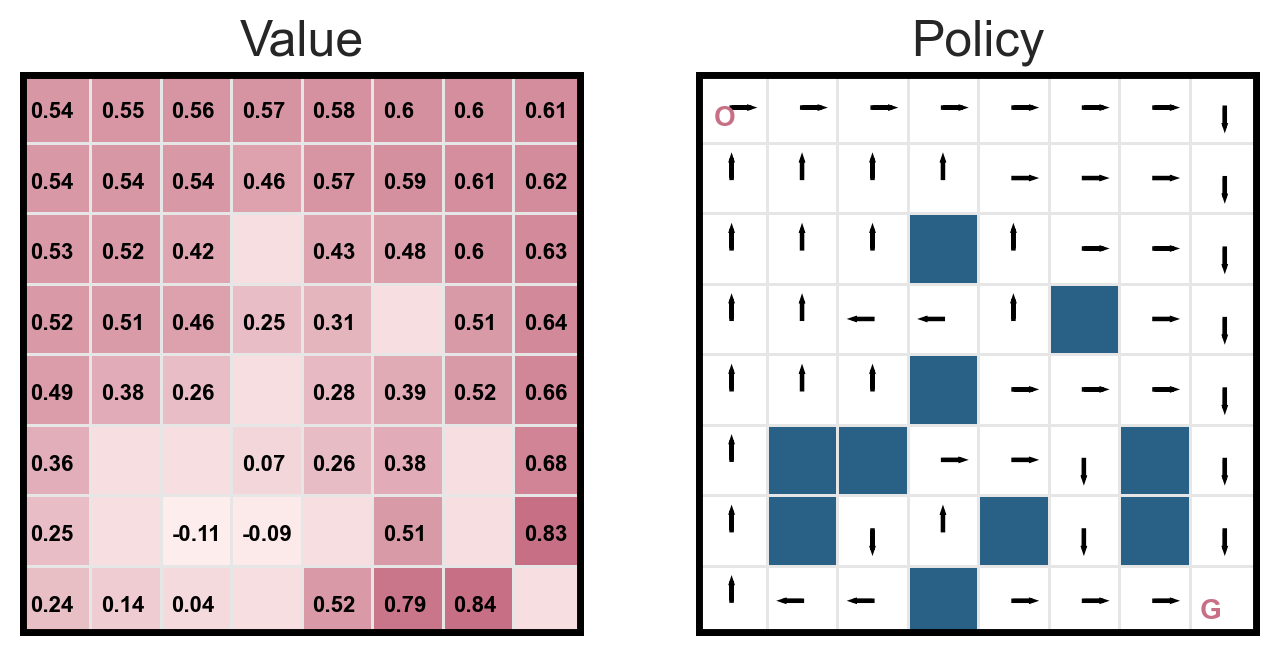

In [28]:
V2, pi2 = value_iter(env, show_value_pi=True)

# 3. Monte Carlo Methods

### 3.1 Roll out 

In [29]:
## Important functions
s_next, r, done = env.reset()
print(s_next, r, done)
# 重置agent的位置到起始点
a = 0
s_next, r, done = env.step(a) 
print(s_next, r, done)
# 执行action a, 返回下一个state, reward, 和是否到达终点

0 None False
0 0 False


In [40]:
def rollout(env, pi, seed=1234, n_episodes=3):
    rng = np.random.RandomState(seed)
    trajectories = {}
    for i in range(n_episodes):
        env = frozen_lake(seed=seed)
        s, _, _ = env.reset()
        trajectory = []
        while True:
            # TODO: sample an action from the policy, a 
            a=rng.choice(env.A, p=pi[s])
            # TODO: use env.step to interact with the environment,
            #       get the next state, reward, and done
            s_next, r, done=env.step(a)
            trajectory.append((s, a, r))
            # TODO: update the state
            s=s_next
            
            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
            clear_output(True)
            env.render(ax)
            time.sleep(.1)
            plt.show()
            if done: break 
        time.sleep(1)  

        trajectories[i] = trajectory
        
    return trajectories

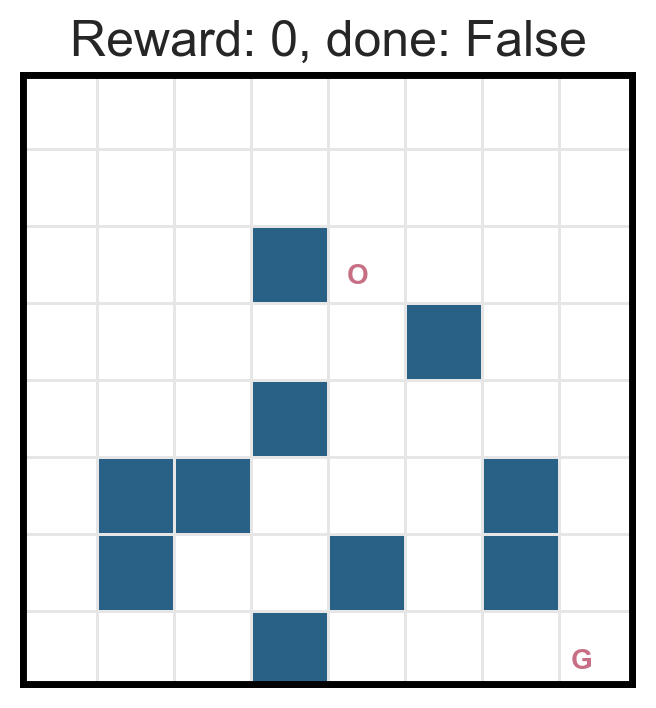

In [31]:
## rollout the episode 
rng = np.random.RandomState(1234)
pi_rand = softmax(rng.rand(env.nS, env.nA)*5, axis=1)
trajectories = rollout(env, pi_rand, seed=1234, n_episodes=3)
    

### 3.2 Monte Carlo Evaluation 

In [41]:
def MC_eval(env, pi, v, seed=1234, n_episodes=10000, gamma=.99, show_value_pi=False):

    # initialize random seed
    rng = np.random.RandomState(seed)
    cumu_rewards = {s: [] for s in env.S}  

    # loop over episodes
    for epi in range(n_episodes):
        # rollout
        s, _, _ = env.reset()
        trajectory = []
        while True:
            a = rng.choice(env.A, p=pi[s])
            s_next, r, done = env.step(a)
            trajectory.append((s, a, r))
            s = s_next
            if done: break
        
        # calculate the cumulative rewards
        G, T = 0, len(trajectory)
        # 一个episode反着走
        for j, step in enumerate(reversed(trajectory)):
            s, a, r = step
            # calculate the cumultive rewards for each tine step
            G=G*gamma+r
            # check if first visit
            prev_visit = [s0 for s0,_,_ in trajectory[:T-j-1]]
            if s not in prev_visit:
                
                cumu_rewards[s].append(G)
                # average the cached cumulative rewards to estimate V(s)
                v[s]=np.mean(cumu_rewards[s])

        if show_value_pi:
            if epi%500==0:
                fig, ax = plt.subplots(1, 1, figsize=(4, 4))
                clear_output(True)
                env.show_v(ax, v)
                time.sleep(.1)
                plt.show()

    return v 

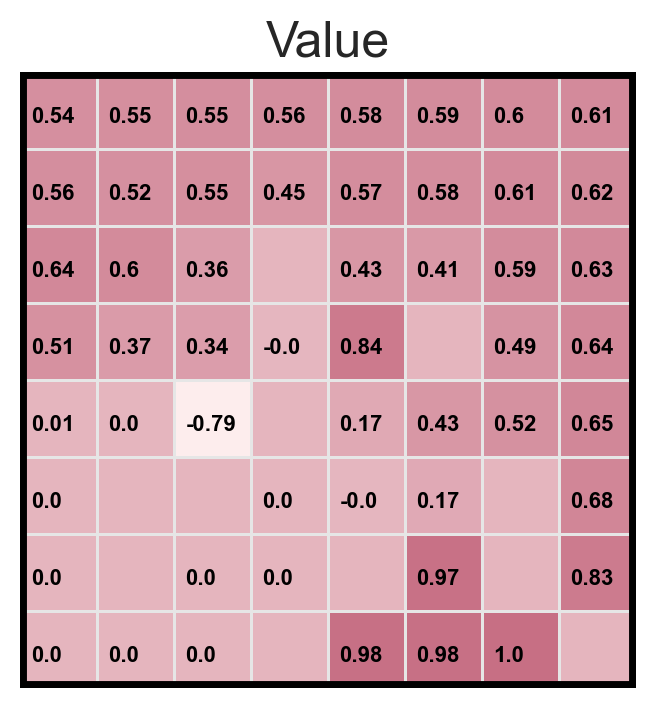

In [42]:
V_mc2 = np.zeros([env.nS,])
V_mc2 = MC_eval(env, pi2, V_mc2, show_value_pi=True)


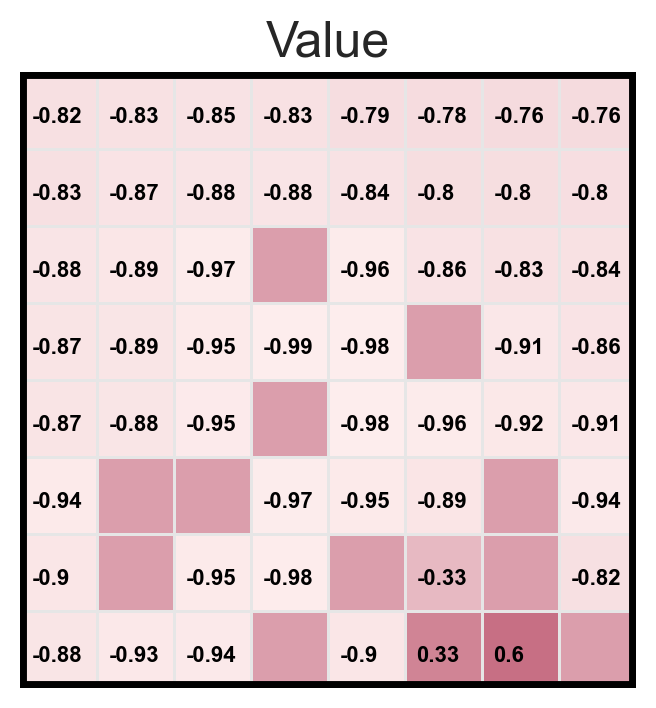

In [93]:
# create “the” random policy
rng = np.random.RandomState(1234)
pi_rand = softmax(rng.rand(env.nS, env.nA)*5, axis=1)
env = frozen_lake(seed=1234)
V_mc = np.zeros([env.nS,])
V_mc = MC_eval(env, pi_rand, V_mc, show_value_pi=True)


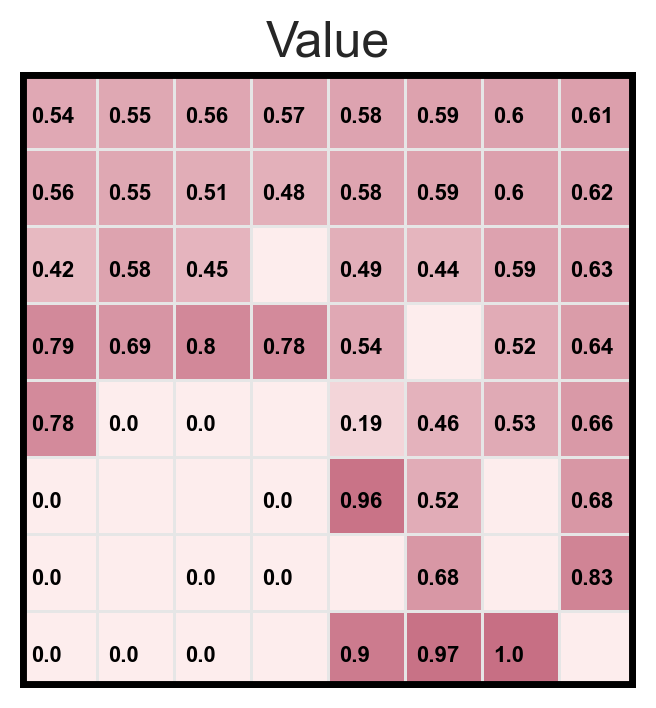